In [23]:
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

valid_data = pd.read_csv('./机器翻译质量评估挑战赛公开数据/valid.txt', sep='\t', header=None)
valid_data = valid_data[~valid_data[2].isnull()]

In [34]:
test_data = pd.read_csv('./机器翻译质量评估挑战赛公开数据/test.txt', sep='\t', header=None)
test_data

,0,1
0,在变电所和供电系统的设计和运行中，基于如下用途必须进行短路电流的计算：,In the design and operation of substations and...
1,The Prostate Testing for Cancer and Treatment ...,前列腺癌检测与治疗（ProtecT）研究比较了PSA检测出前列腺癌的男性患者的前列腺切除术与...
2,Particles with nonzero electric charge interac...,电电荷为非零的粒子通过交换光子（电磁力的载体）相互作用。
3,"中国的一个租船人,租了一条10万吨的美国船东的油轮,从上海装货去美国。",A Chinese charterer chartered a 100000 ton tan...
4,为了节省成本，运营商在5G建网初期都会选择NSA。,"In order to save costs, operators will choose ..."
...,...,...
495,在周五黄昏巨浪冲击海岸时，有数百人聚集在海滩庆祝节日，很多人被巨浪冲走，巨浪所到之处一切尽毁。,Hundreds of people gathered on the beach to ce...
496,我不确定。但在我们解决之前不要做任何事。,"Well, I'm not sure. But don't do anything unti..."
497,在本法规定的范围以外需要悬挂国微或者使用国徽图案的，由全国人民代表大会常务委员会办公厅或者国...,If it is necessary to hang the national emblem...
498,贸易的吹鼓手们对此负有一定的责任。,The trade drummers are responsible for this.


In [24]:
from langdetect import detect_langs
a = detect_langs("屏幕需要稍加区别对待。")[0]

In [25]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'two', 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate, weights=[1])
print(score)

0.75


In [26]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "This is two example sentence"]
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = normalize(model.encode(sentences))

embeddings[0].dot(embeddings[1])

0.88148904

In [27]:
from transformers import pipeline
# pipe = pipeline("text2text-generation", model="Helsinki-NLP/opus-mt-zh-en", device='cuda:0')
pipe = pipeline("text2text-generation", model="/home/lyz/huggingface-models/Helsinki-NLP/opus-mt-zh-en", device='cuda:0')

In [28]:
result = []
for row in tqdm_notebook(valid_data.iterrows()):
    str1 = row[1].iloc[0]
    str2 = row[1].iloc[1]
    score = row[1].iloc[2]
    
    if detect_langs(str1)[0].lang == 'zh-cn':
        pass
    else:
        str1, str2 = str2, str1
    
    str1_translate = pipe(str1)[0]['generated_text']
    bleu_score = sentence_bleu([str2.split()], str1_translate.split(), weights=[1])
    
    sentences = [str2, str1_translate]
    embeddings = normalize(model.encode(sentences))
    sentence_score = embeddings[0].dot(embeddings[1])
    
    result.append([bleu_score, sentence_score, score])

/tmp/ipykernel_9659/4261872139.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for row in tqdm_notebook(valid_data.iterrows()):


0it [00:00, ?it/s]

<Axes: xlabel='0', ylabel='2'>

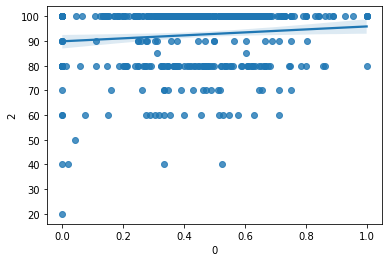

In [29]:
sns.regplot(x=pd.DataFrame(result)[0], y=pd.DataFrame(result)[2])

<Axes: xlabel='1', ylabel='2'>

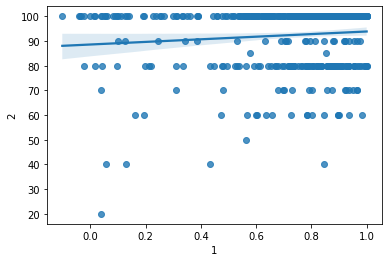

In [30]:
sns.regplot(x=pd.DataFrame(result)[1], y=pd.DataFrame(result)[2])

In [31]:
from sklearn.linear_model import LinearRegression

m = LinearRegression()
m.fit(pd.DataFrame(result).iloc[:, :2], pd.DataFrame(result).iloc[:, 2])

LinearRegression()

<Axes: ylabel='2'>

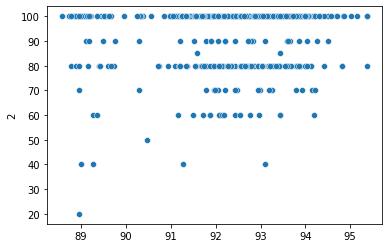

In [33]:
sns.scatterplot(x=m.predict(pd.DataFrame(result).iloc[:, :2]), y=pd.DataFrame(result).iloc[:, 2])

In [35]:
result = []
for row in tqdm_notebook(test_data.iterrows()):
    str1 = row[1].iloc[0]
    str2 = row[1].iloc[1]
    
    if detect_langs(str1)[0].lang == 'zh-cn':
        pass
    else:
        str1, str2 = str2, str1
    
    str1_translate = pipe(str1)[0]['generated_text']
    bleu_score = sentence_bleu([str2.split()], str1_translate.split(), weights=[1])
    
    sentences = [str2, str1_translate]
    embeddings = normalize(model.encode(sentences))
    sentence_score = embeddings[0].dot(embeddings[1])
    
    result.append([bleu_score, sentence_score])

/tmp/ipykernel_9659/1336079783.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for row in tqdm_notebook(test_data.iterrows()):


0it [00:00, ?it/s]

In [40]:
pd.DataFrame({
    'uuid': range(500),
    'label': m.predict(pd.DataFrame(result).iloc[:, :2]) // 5 * 5
}).astype(int).to_csv('sub.csv', index=None)